In [1]:
conda install -c anaconda line_profiler

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/dennisjoshy/anaconda3

  added / updated specs:
    - line_profiler


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.8.28  |                0         133 KB  anaconda
    certifi-2019.9.11          |           py37_0         154 KB  anaconda
    conda-4.8.3                |           py37_0         3.0 MB  anaconda
    line_profiler-2.1.2        |   py37h1de35cc_0          55 KB  anaconda
    openssl-1.1.1d             |       h1de35cc_2         3.4 MB  anaconda
    ------------------------------------------------------------
                                           Total:         6.8 MB

The following NEW pa

In [3]:
import multiprocessing

# NumPy and odeint, our workhorses
import numpy as np
import scipy.stats as st
import numba 

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Line profiler (you might not have this installed)
%load_ext line_profiler

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In [4]:
# Column 0 is change in m, column 1 is change in p
simple_update = np.array([[1, 0],
                          [-1, 0],
                          [0, 1],
                          [0, -1]], dtype=np.int)

## Calculating Propensities

In [5]:
def simple_propensity(params, population):
    """
    Returns an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack parameters
    alpha1, alpha2, beta, gamma = params
    
    # Unpack population
    m, p = population
    
    return np.array([alpha1/(1 + p**(beta)), 
                     m, 
                     alpha2/(1 + m**(gamma)), 
                     p])

## Drawing the Reaction

In [6]:
def sample_discrete(probs):
    """
    Randomly sample an index with probability given by probs.
    """
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

## Returning draw and time

In [7]:
# Function to draw time interval and choice of reaction
def gillespie_draw(params, propensity_func, population):
    """
    Draws a reaction and the time it took to do that reaction.
    """
    # Compute propensities
    props = propensity_func(params, population)
    
    # Sum of propensities
    props_sum = props.sum()
    
    # Compute time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = props / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

## Main code

In [8]:
def gillespie_ssa(params, propensity_func, update, population_0, 
                  time_points):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    params : arbitrary
        The set of parameters to be passed to propensity_func.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(params, propensity_func, population)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

## running 

In [9]:
# Specify parameters for calculation
params = np.array([100, 5, 2.5, 1])
time_points = np.linspace(0, 50, 101)
population_0 = np.array([1000, 1000])
n_simulations = 100

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty((n_simulations, len(time_points), 2))

# Run the calculations
for i in range(n_simulations):
    pops[i,:,:] = gillespie_ssa(params, simple_propensity, simple_update,
                                population_0, time_points)

# Looped simulation

In [44]:
a1_count = 0
a2_count = 0
a1_div = 6
a2_div = 6
time_points = np.linspace(0, 50, 101)
population_0 = np.array([2000, 2000])
n_simulations = 100
# Seed random number generator for reproducibility
np.random.seed(42)
pops = np.empty((n_simulations, len(time_points), 2, a1_div,a2_div))
for a1 in np.logspace(1, 3, a1_div):
    a2_count = 0
    for a2 in 15*np.logspace(-0.5, 0.5, a2_div):
# Specify parameters for calculation
        params = np.array([a1, a2, 2.5, 1]) 
        # Initialize output array

        # Run the calculations
        for i in range(n_simulations):
            pops[i,:,:,a1_count,a2_count] = gillespie_ssa(params, simple_propensity, simple_update,
                                        population_0, time_points)
        a2_count+=1
        print(a1_count,a2_count)
    a1_count+=1

0 1
0 2
0 3
0 4
0 5
0 6
1 1
1 2
1 3
1 4
1 5
1 6
2 1
2 2
2 3
2 4
2 5
2 6
3 1
3 2
3 3
3 4
3 5
3 6
4 1
4 2
4 3
4 4
4 5
4 6
5 1
5 2
5 3
5 4
5 5
5 6


## Visualization

In [ ]:
# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot mRNA trajectories
for i in range(n_simulations):
    ax[0].plot(time_points, pops[i,:,0], '-', lw=0.3, alpha=0.2, 
               color=sns.color_palette()[0])

# Plot mRNA mean
ax[0].plot(time_points, pops[:,:,0].mean(axis=0), '-', lw=6, 
           color=sns.color_palette()[2])

# Plot protein trajectories
for i in range(n_simulations):
    ax[1].plot(time_points, pops[i,:,1], 'k-', lw=0.3, alpha=0.2,
               color=sns.color_palette()[0])

# Plot protein mean
ax[1].plot(time_points, pops[:,:,1].mean(axis=0), 'r-', lw=6, 
           color=sns.color_palette()[2])

# Label axes
ax[0].set_xlabel('dimensionless time')
ax[1].set_xlabel('dimensionless time')
ax[0].set_ylabel('number of mRNAs')
ax[1].set_ylabel('number of proteins')
plt.tight_layout()

In [ ]:
# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot mRNA trajectories
for i in range(n_simulations):
    ax[0].plot(time_points, pops[i,:,0], '-', lw=0.3, alpha=0.2, 
               color=sns.color_palette()[0])

# Plot mRNA mean
ax[0].plot(time_points, pops[:,:,0].mean(axis=0), '-', lw=6, 
           color=sns.color_palette()[2])

# Plot protein trajectories
for i in range(n_simulations):
    ax[1].plot(time_points, pops[i,:,1], 'k-', lw=0.3, alpha=0.2,
               color=sns.color_palette()[0])

# Plot protein mean
ax[1].plot(time_points, pops[:,:,1].mean(axis=0), 'r-', lw=6, 
           color=sns.color_palette()[2])

# Label axes
ax[0].set_xlabel('dimensionless time')
ax[1].set_xlabel('dimensionless time')
ax[0].set_ylabel('number of mRNAs')
ax[1].set_ylabel('number of proteins')
plt.tight_layout()

# Parametric Sweep Visualization

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

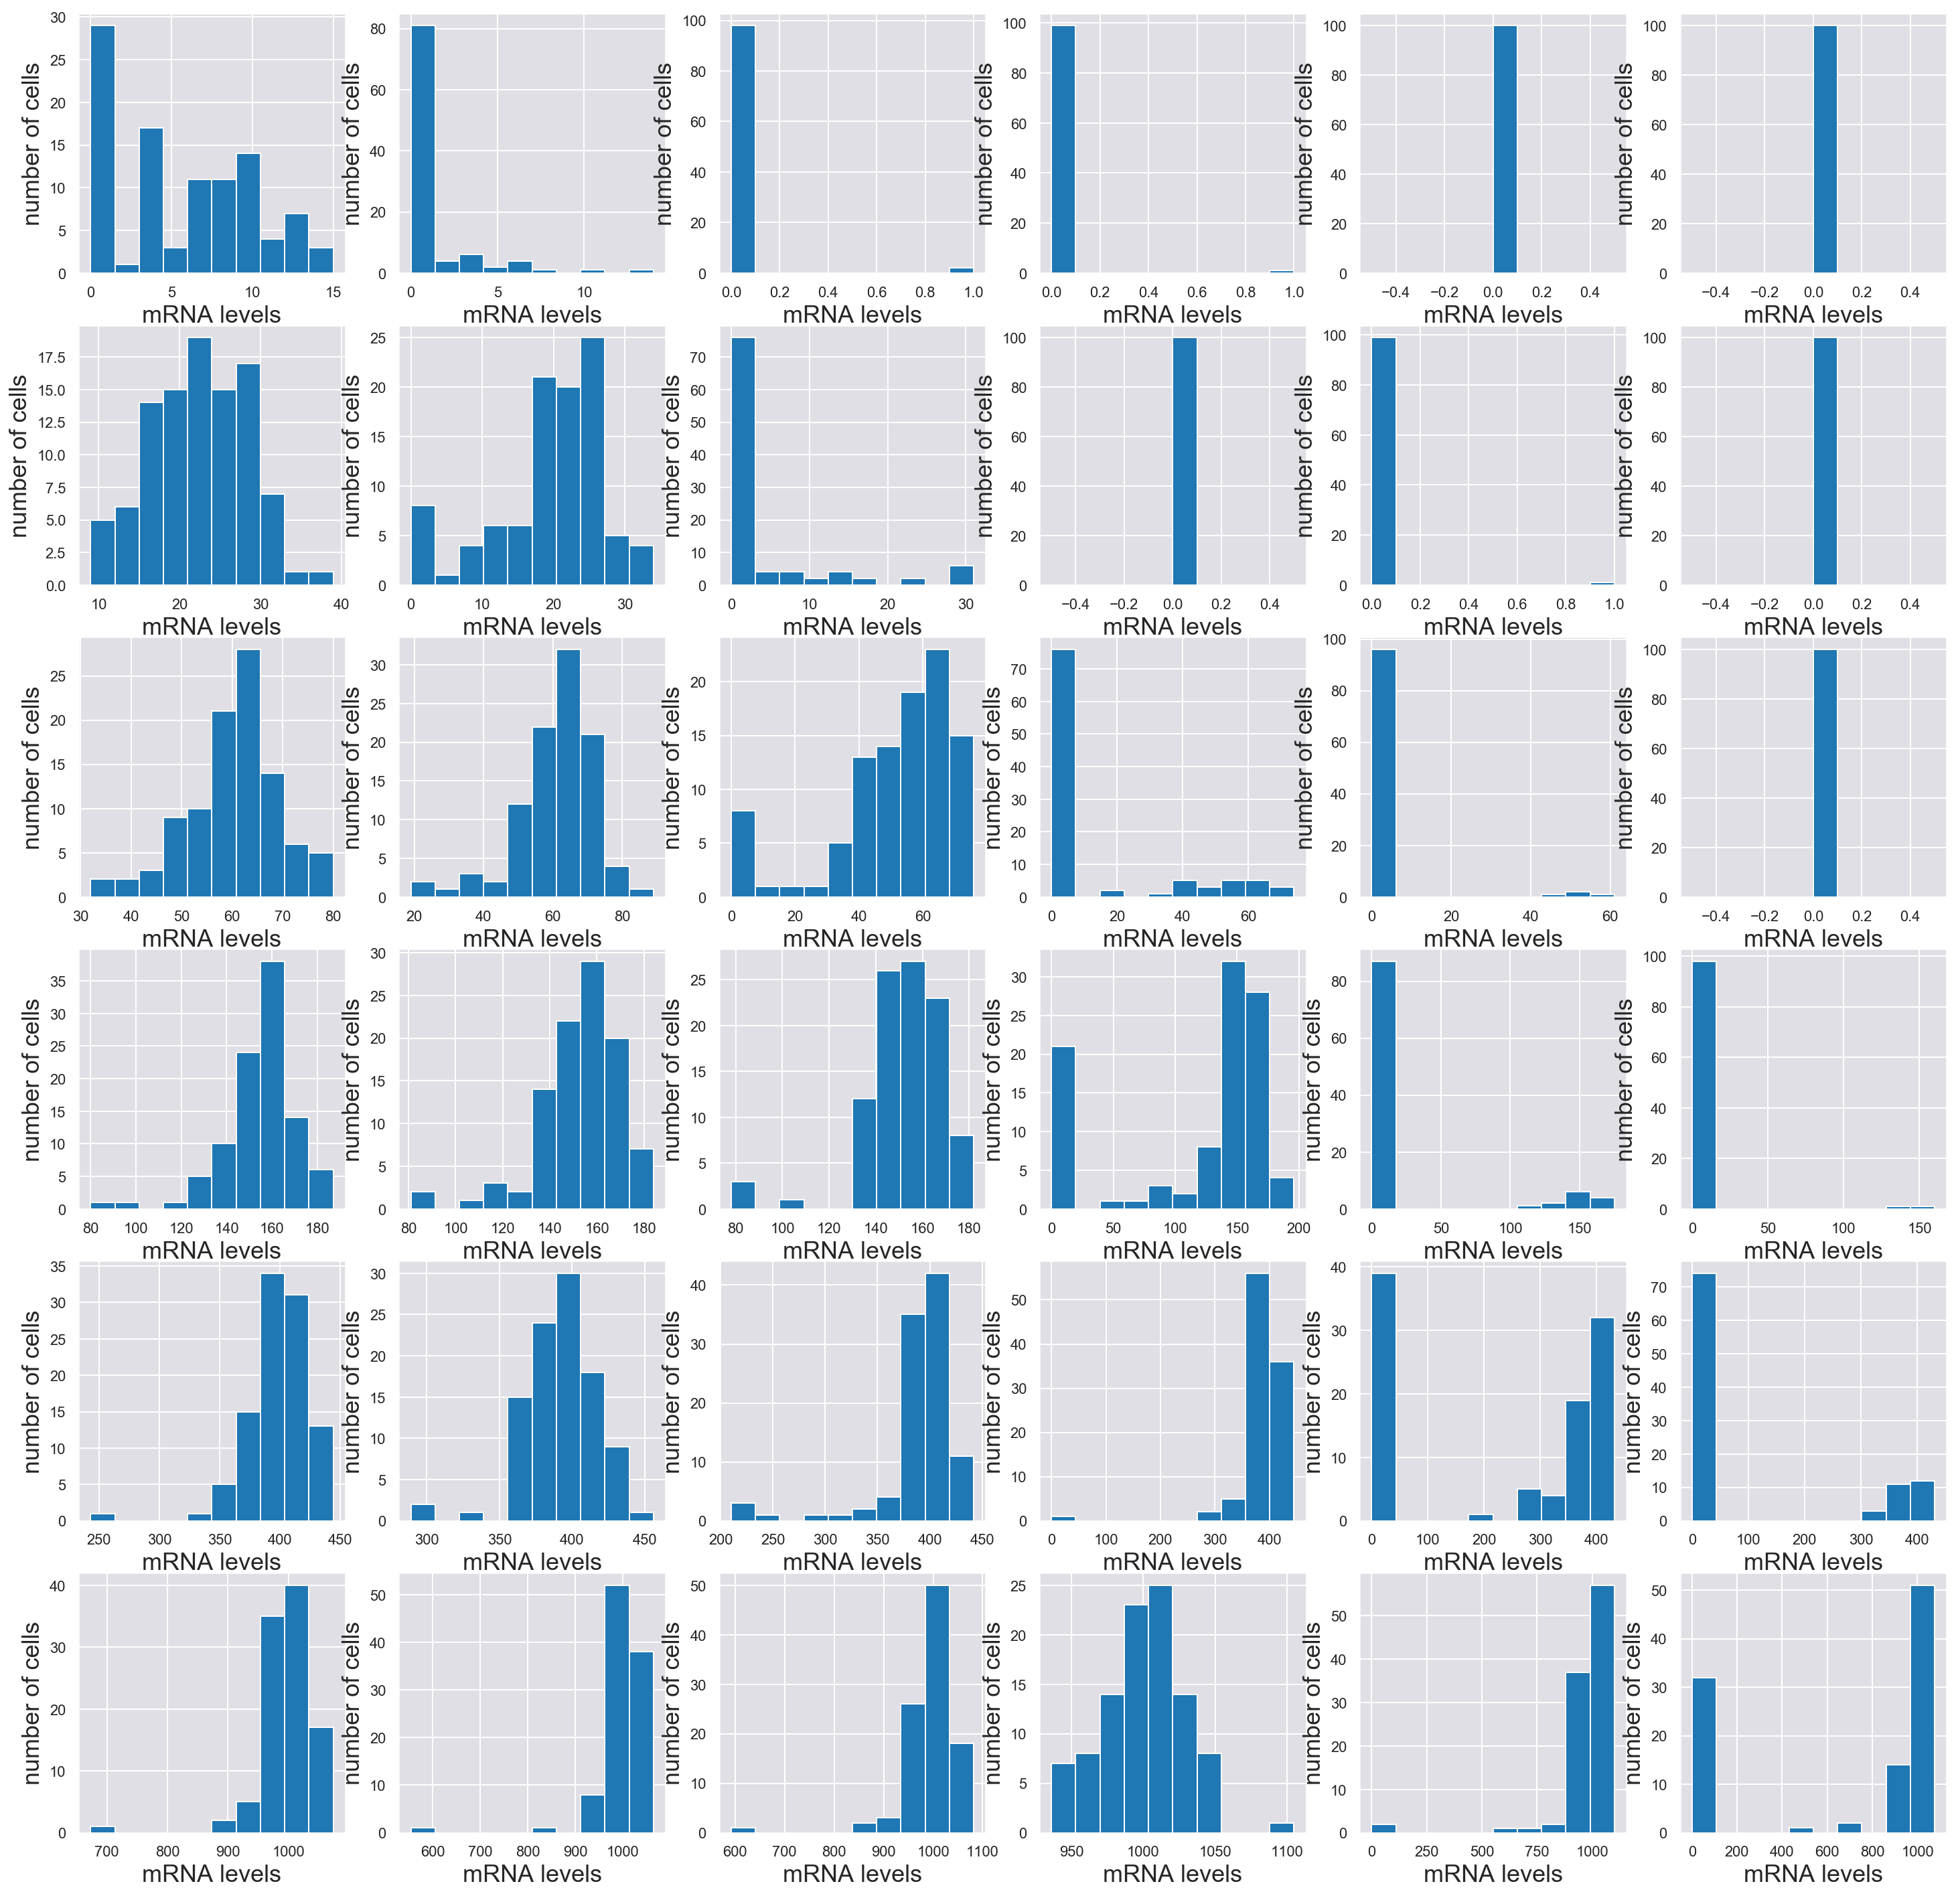

In [54]:
# Set up subplots
fig, ax = plt.subplots(a1_div, a2_div, figsize=(25, 25))

for a1 in range(0,len(np.logspace(1, 3, a1_div))):
    for a2 in range(0,len(15*np.logspace(-0.5, 0.5, a2_div))):

    # Converting populations to histograms
        p_hist = np.hstack(pops[:,-1,0,a1 ,a2])
        ax[a1,a2].hist(p_hist, bins=10)

    # Label axes
        ax[a1,a2].set_xlabel('mRNA levels')
        #ax[a1,a2].set_xlabel('dimensionless time')
        ax[a1,a2].set_ylabel('number of cells')
        #ax[a1,a2].set_ylabel('number of proteins')
plt.tight_layout


In [ ]:
# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot mRNA trajectories
for i in range(n_simulations):
    ax[0].plot(time_points, pops[i,:,0], '-', lw=0.3, alpha=0.2, 
               color=sns.color_palette()[0])

# Plot mRNA mean
ax[0].plot(time_points, pops[:,:,0].mean(axis=0), '-', lw=6, 
           color=sns.color_palette()[2])

# Plot protein trajectories
for i in range(n_simulations):
    ax[1].plot(time_points, pops[i,:,1], 'k-', lw=0.3, alpha=0.2,
               color=sns.color_palette()[0])

# Plot protein mean
ax[1].plot(time_points, pops[:,:,1].mean(axis=0), 'r-', lw=6, 
           color=sns.color_palette()[2])

# Label axes
ax[0].set_xlabel('dimensionless time')
ax[1].set_xlabel('dimensionless time')
ax[0].set_ylabel('number of mRNAs')
ax[1].set_ylabel('number of proteins')
plt.tight_layout()

In [ ]:
p_hist = np.hstack(pops[:,-1,0])
plt.hist(p_hist, bins=100)

In [ ]:
pops[:,-1,0]

In [ ]:
pops = np.empty((n_simulations, len(time_points)))
(pops)

In [31]:
 test_array = (np.empty((2,2,2,2)))

In [30]:
for a1 in 15*np.logspace(-0.5, 0.5, 6):
# Specify parameters for calculation
    params = np.array([100, a1, 2.5, 1])
    print(params)

[100.           4.74341649   2.5          1.        ]
[100.          7.5178085   2.5         1.       ]
[100.          11.91492352   2.5          1.        ]
[100.          18.88388118   2.5          1.        ]
[100.          29.92893472   2.5          1.        ]
[100.         47.4341649   2.5         1.       ]


In [37]:
a1_count = 0
a2_count = 0
a1_div = 3
a2_div = 6
time_points = np.linspace(0, 50, 101)
population_0 = np.array([2000, 2000])
pops = np.empty((n_simulations, len(time_points), 2,a1_div*a2_div))

In [39]:
len(pops[1,:,:,0])

101